In [1]:
%matplotlib notebook
from poses import Poses
from poses import plot
from calibration import calibrate
import numpy as np

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
from poses.utils.lie_groups import SE3, SO3
import copy

# Get poses

In [3]:
bag_file_path = "/home/eric/Documents/Research/20_10_ExCalib/MCaV/input_data/lidar_odom.bag"
gps_topic = "/gps_pose"
lidar_topic = "/odom"

## GPS poses

In [4]:
gps_poses = Poses.from_pose_bag(gps_topic, bag_file_path)

[INFO]  Data folder /home/eric/Documents/Research/20_10_ExCalib/MCaV/input_data/lidar_odom already exists. Not creating.


## Lidar poses

In [5]:
lidar_poses = Poses.from_pose_bag(lidar_topic, bag_file_path)

[INFO]  Data folder /home/eric/Documents/Research/20_10_ExCalib/MCaV/input_data/lidar_odom already exists. Not creating.


In [6]:
# Rotating the entire trajectory has no effects on the calibration output
# rotation_trajectory = np.array(
# [[0.0, 1.0, 0.0, 0.0],
#  [0.0, 0.0, 1.0, 0.0],
#  [1.0, 0.0, 0.0, 0.0],
#  [0.0, 0.0, 0.0, 1.0]])

# lidar_poses.transform_pose_(rotation_trajectory)

In [7]:
# rotation_orientation = np.array(
# [[0.0, 0.0, 1.0],
#  [1.0, 0.0, 0.0],
#  [0.0, 1.0, 0.0]])

# lidar_poses.rotate_orientation_(rotation_orientation)

## Interpolate poses

In [8]:
sync_timestamps = lidar_poses.sync_(gps_poses.timestamps)
gps_poses.sync_(sync_timestamps)

array([1.60391548e+09, 1.60391548e+09, 1.60391548e+09, ...,
       1.60391562e+09, 1.60391562e+09, 1.60391562e+09])

# Plot poses

<IPython.core.display.Javascript object>


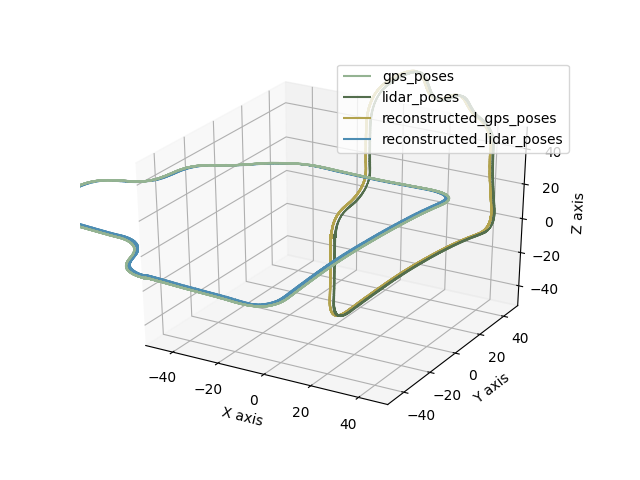

In [9]:
named_trajectories = {"gps_poses" : np.hstack((gps_poses.trajectory(), gps_poses.orientation())),
                      "lidar_poses": np.hstack((lidar_poses.trajectory(), lidar_poses.orientation()))}

plot(named_trajectories)

# Calibrate

In [10]:
T1, cov1 = gps_poses.egomotion()
T2, cov2 = lidar_poses.egomotion()

In [11]:
# LiDAR to GPS transformation
R_star, t_star, statusSuccess, duality_gap = calibrate(T1, T2, cov1, cov2)

if statusSuccess:
    print("GPS expressed in LiDAR frame\n")
    print("Orientation:")
    print(R_star)
    print("\nTranslation:")
    print(t_star)
    print("\nDuality gap: " + str(duality_gap))
else:
    print("Program Failed")

GPS expressed in LiDAR frame

Orientation:
[[ 0.06709071 -0.01441134  0.997809  ]
 [ 0.99791436 -0.00129347 -0.06711609]
 [ 0.00223969  0.99987638  0.01429618]]

Translation:
[[-1.51815314]
 [ 0.24571558]
 [-1.22893502]]

Duality gap: 7.201276163282348e-07


In [12]:
# GPS to LiDAR transformation
R_star_inv, t_star_inv, statusSuccess, duality_gap = calibrate(T2, T1, cov2, cov1)

if statusSuccess:
    print("LiDAR expressed in GPS frame\n")
    print("Orientation:")
    print(R_star_inv)
    print("\nTranslation:")
    print(t_star_inv)
    print("\nDuality gap: " + str(duality_gap))
else:
    print("Program Failed")

LiDAR expressed in GPS frame

Orientation:
[[ 6.22255490e-02  9.98009320e-01  1.93538010e-03]
 [-1.52221966e-02 -9.86878125e-04  9.99876357e-01]
 [ 9.97893301e-01 -6.22475817e-02  1.51315036e-02]]

Translation:
[[0.657753  ]
 [1.13161619]
 [0.44329539]]

Duality gap: 1.189560025952968e-05


In [13]:
T_star = np.block([[R_star, t_star], [0, 0, 0, 1]])
T_star_inv = np.block([[R_star_inv, t_star_inv], [0, 0, 0, 1]])

print(T_star_inv @ T_star) # Error: this should be identity

[[ 1.00010693e+00 -2.52508573e-04 -4.86560526e-03  8.06133064e-01]
 [ 2.33325854e-04  9.99973401e-01 -8.28199662e-04 -7.42997455e-02]
 [ 4.86550194e-03  8.29166856e-04  1.00010105e+00 -1.10555029e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# Reconstruct GPS pose from LiDAR

In [14]:
GPS_poses_from_transform = np.array([
    src_pose @ T_star for src_pose in lidar_poses.poses
])

In [15]:
reconstructed_gps_trajectory = GPS_poses_from_transform[:, 0:3, 3]
reconstructed_gps_orientation = GPS_poses_from_transform[:, 0:3, 1]
named_trajectories = {"reconstructed_gps_poses": np.hstack((reconstructed_gps_trajectory, reconstructed_gps_orientation))}

plot(named_trajectories)

# Reconstruct LiDAR pose from GPS

In [16]:
LiDAR_poses_from_transform = np.array([
    src_pose @ T_star_inv for src_pose in gps_poses.poses
])

In [17]:
reconstructed_lidar_trajectory = LiDAR_poses_from_transform[:, 0:3, 3]
reconstructed_lidar_orientation = LiDAR_poses_from_transform[:, 0:3, 1]
named_trajectories = {"reconstructed_lidar_poses": np.hstack((reconstructed_lidar_trajectory, reconstructed_lidar_orientation))}

plot(named_trajectories)